In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

from sklearn.model_selection import train_test_split,cross_val_score,KFold,RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,precision_recall_curve,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from mlxtend.classifier import StackingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

Import the data and drop decade information, as this can't be decided.

In [3]:
critic_table = pd.read_pickle('critic_edad.pkl')
critic_table = critic_table.drop(['decade_old','decade_80s','decade_70s'],axis=1)

Create a data holdout.

In [4]:
train,test = train_test_split(critic_table,shuffle=True,test_size=.2,random_state=8)
kf = KFold(n_splits=4,shuffle=True,random_state=8)

Check the balance of classes in our train and test.

In [5]:
len(test[test.critic==1])/len(test)

0.44983089064261556

In [6]:
len(train[train.critic==1])/len(train)

0.482943332393572

In [7]:
len(critic_table[critic_table.critic==1])/len(critic_table)

0.476319350473613

### Not too bad, but eh... Let's stratify!

In [8]:
def train_test_better(matrix,stratifier) :
    cat1 = matrix[matrix[stratifier]==1]
    cat2 = matrix[matrix[stratifier]==0]
    tr1,te1 = train_test_split(cat1,shuffle=True,test_size=.2,random_state=9)
    tr2,te2 = train_test_split(cat2,shuffle=True,test_size=.2,random_state=9)
    train = pd.DataFrame(pd.concat([tr1,tr2],axis=0))
    train = train.sample(frac=1)
    test = pd.DataFrame(pd.concat([te1,te2],axis=0))
    test = test.sample(frac=1)
    return train,test

Better.

In [9]:
train, test = train_test_better(critic_table,'critic')

In [10]:
len(train[train.critic==1])/len(train)

0.4763113367174281

In [11]:
len(test[test.critic==1])/len(test)

0.47635135135135137

In [12]:
len(critic_table[critic_table.critic==1])/len(critic_table)

0.476319350473613

In [13]:
X = train.drop(['critic'],axis=1)
y = train['critic']

### Naive classifiers to test against class-balanced data

In [14]:
rf = RandomForestClassifier(n_estimators=100,random_state=8,max_depth=11)
cross_val_score(rf,X,y,scoring='accuracy',cv=kf).mean()

0.6937342374554959

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr = LogisticRegression(solver='lbfgs',random_state=8)
cross_val_score(lr,X_scaled,y,scoring='accuracy',cv=kf).mean()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.6559496209354585

### Balanced data results
The difference is minimal with both under and oversampling (and I don't want to purposefully warp the data far from its origin), so I'm going to leave be.

In [16]:
len(X[y==0])

1857

In [17]:
len(X[y==1])

1689

Oversampling class 1.

In [18]:
from imblearn.over_sampling import SMOTE
Xb, yb = SMOTE(random_state=8,sampling_strategy={0:1857,1:1857}).fit_sample(X,y)

In [19]:
rf = RandomForestClassifier(n_estimators=100,random_state=8,max_depth=11)
cross_val_score(rf,Xb,yb,scoring='accuracy',cv=kf).mean()

0.6892750013919305

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xb)
lr = LogisticRegression(solver='lbfgs',random_state=8)
cross_val_score(lr,X_scaled,yb,scoring='accuracy',cv=kf).mean()

0.651312416484169

Undersampling class 0.

In [21]:
from imblearn.under_sampling import RandomUnderSampler
Xb, yb = RandomUnderSampler(random_state=42,ratio={0:1689,1:1689}).fit_sample(X,y)

In [22]:
rf = RandomForestClassifier(n_estimators=100,random_state=8,max_depth=11)
cross_val_score(rf,Xb,yb,scoring='accuracy',cv=kf).mean()

0.685624596875964

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xb)
lr = LogisticRegression(solver='lbfgs',random_state=8)
cross_val_score(lr,X_scaled,yb,scoring='accuracy',cv=kf).mean()

0.658383928321041

# Models

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### SVM
I'm only running this once because it's the literal worst, I fully know how to do it, I just don't want to spend all my time on one model.

In [29]:
svc_params = {'C': np.linspace(1e-7,1e2,20),'gamma':np.linspace(1e-7,1e2,20)}

In [30]:
svc_gridsearch = SVC(random_state=8,kernel='poly',degree=1)
rando = RandomizedSearchCV(svc_gridsearch,param_distributions=svc_params,n_iter=20,scoring='precision',
                           random_state=8,cv=kf)
rando = rando.fit(X_scaled,y)
rando.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarnin

{'gamma': 31.578947436842107, 'C': 15.789473768421052}

In [27]:
svc_gridsearch = SVC(random_state=8,kernel='rbf')
rando = RandomizedSearchCV(svc_gridsearch,param_distributions=svc_params,n_iter=20,scoring='precision',
                           random_state=8,cv=kf)
rando = rando.fit(X_scaled,y)
rando.best_params_

{'gamma': 7.692307784615385, 'C': 38.461538523076925}

In [28]:
svc = SVC(kernel='rbf',gamma=7.69,C=38,random_state=8)
print(cross_val_score(svc,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(svc,X_scaled,y,scoring='recall',cv=kf).mean())

0.5731740864227638
0.6890809319810168


In [49]:
# I accidentally ran two gridsearches but I do NOT want to run two SVMs, so we leave this here.

### Random Forest
Best precision : 71% <br />
Best recall : 57%

In [25]:
rf_params = {'criterion':['gini','entropy'],'max_depth':list(range(1,23))}

In [26]:
rf_gridsearch = RandomForestClassifier(n_estimators=100,random_state=8)
rando = RandomizedSearchCV(rf_gridsearch,param_distributions=rf_params,n_iter=40,scoring='precision',
                               random_state=8,cv=kf)
rando = rando.fit(X,y)
rando.best_params_

{'max_depth': 5, 'criterion': 'gini'}

In [27]:
rf = RandomForestClassifier(random_state=8,n_estimators=100,criterion='gini',max_depth=5)
print(cross_val_score(rf,X,y,scoring='precision',cv=kf).mean())
print(cross_val_score(rf,X,y,scoring='recall',cv=kf).mean())

0.7117871142550782
0.5736487773310793


In [28]:
rf.fit(X,y)
sorted(list(zip(X.columns,rf.feature_importances_)), key = lambda x : x[1])

[('War', 0.002584435124775278),
 ('country_France', 0.003272198712523027),
 ('History', 0.005600986361308481),
 ('rating_andre', 0.009489706945171941),
 ('Documentary', 0.010881118146392341),
 ('country_UK', 0.013965501208746005),
 ('language_andre', 0.01448199547391179),
 ('Horror', 0.01845406902592091),
 ('Biography', 0.028238148979011998),
 ('starpower', 0.03299967538182821),
 ('Action', 0.055805320951089595),
 ('actor_1_fb', 0.06654920307504227),
 ('rating_PG-13', 0.0795255722944759),
 ('actor_2_fb', 0.08049345408767287),
 ('actor_3_fb', 0.10178454678788876),
 ('director_fb', 0.14838664837148222),
 ('runtime', 0.15623352682185174),
 ('budget', 0.17125389225090668)]

As we see in the next three cells, dropping the least important feature doesn't help.

In [29]:
rf_gridsearch = RandomForestClassifier(n_estimators=100,random_state=8)
rando = RandomizedSearchCV(rf_gridsearch,param_distributions=rf_params,n_iter=40,scoring='precision',
                               random_state=8,cv=kf)
rando = rando.fit(X.drop('War',axis=1),y)
rando.best_params_

{'max_depth': 3, 'criterion': 'entropy'}

In [30]:
rf = RandomForestClassifier(random_state=8,n_estimators=100,criterion='entropy',max_depth=3)
print(cross_val_score(rf,X.drop('War',axis=1),y,scoring='precision',cv=kf).mean())
print(cross_val_score(rf,X.drop('War',axis=1),y,scoring='recall',cv=kf).mean())

0.7093289857414431
0.5251132767755547


Here I get rid of 'starpower' (the 7th most important). Still little change, so we'll keep our first model.

In [31]:
rf_gridsearch = RandomForestClassifier(n_estimators=100,random_state=8)
rando = RandomizedSearchCV(rf_gridsearch,param_distributions=rf_params,n_iter=40,scoring='precision',
                               random_state=8,cv=kf)
rando = rando.fit(X.drop('actor_2_fb',axis=1),y)
rando.best_params_

{'max_depth': 1, 'criterion': 'entropy'}

In [32]:
rf = RandomForestClassifier(random_state=8,n_estimators=100,criterion='entropy',max_depth=1)
print(cross_val_score(rf,X.drop('actor_2_fb',axis=1),y,scoring='precision',cv=kf).mean())
print(cross_val_score(rf,X.drop('actor_2_fb',axis=1),y,scoring='recall',cv=kf).mean())

0.7132999370786727
0.3465779853725276


### KNeighbours
High precision/low recall : .97,.01 <br />
With a minimum recall : .74, .35

In [33]:
knn_params = {'n_neighbors':list(range(1,1501)),'weights':['uniform','distance']}

In [34]:
knn_gridsearch = KNeighborsClassifier()
rando = RandomizedSearchCV(knn_gridsearch,param_distributions=knn_params,n_iter=100,scoring='precision',
                               random_state=8,cv=kf)
rando = rando.fit(X_scaled,y)
rando.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarnin

{'weights': 'uniform', 'n_neighbors': 1321}

In [35]:
knn = KNeighborsClassifier(n_neighbors=1321,weights='uniform')
print(cross_val_score(knn,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(knn,X_scaled,y,scoring='recall',cv=kf).mean())

0.9722222222222222
0.011972733157881332


Here I try many knns in order to try to then find one with an acceptable recall.

In [36]:
precisions = []
recalls = []
for i in range(1,1502,10) :
    clear_output()
    print(i)
    knn=KNeighborsClassifier(n_neighbors=i,weights='uniform')
    precisions.append(cross_val_score(knn,X_scaled,y,scoring='precision',cv=kf))
    recalls.append(cross_val_score(knn,X_scaled,y,scoring='recall',cv=kf))

1501


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
p_means = [x.mean() for x in precisions]
r_means = [x.mean() for x in recalls]

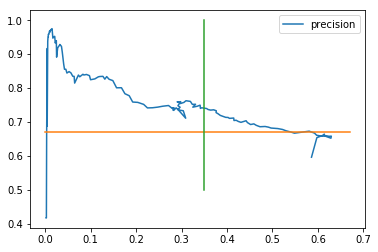

In [38]:
plt.plot(r_means,p_means,label='precision')
plt.plot([0,.67],[.67,.67])
plt.plot([.35,.35],[.5,1])
plt.legend()

Narrowing the range for the acceptable recall boundary.

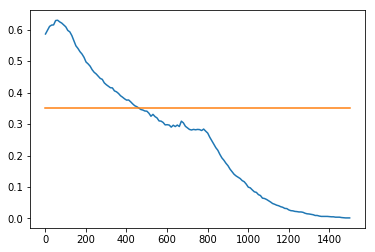

In [39]:
plt.plot(list(range(1,1502,10)),r_means,label='recall')
plt.plot([0,1501],[.35,.35]);

In [51]:
prec = 1000
recall = 1000
neighbors = 1000
for i in range(450,476) :
    knn=KNeighborsClassifier(n_neighbors=i,weights='uniform')
    recall_t = cross_val_score(knn,X_scaled,y,scoring='recall',cv=kf).mean()
    if recall_t >= .35 :
        prec = cross_val_score(knn,X_scaled,y,scoring='precision',cv=kf).mean()
        recall = cross_val_score(knn,X_scaled,y,scoring='recall',cv=kf).mean()
        neighbors=i
    elif recall<.35 :
        break

Now that we've gone up to the very last neighbours option with a recall greater than .35, let's see what that number is.

In [53]:
print(neighbors)

463


In [54]:
knn = KNeighborsClassifier(n_neighbors=463,weights='uniform')
print(cross_val_score(knn,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(knn,X_scaled,y,scoring='recall',cv=kf).mean())

0.7409368159800737
0.3503519432789438


### Logistic Regression
Precision = .68 <br />
Recall = .52

In [55]:
lr_params = {'solver':['saga','lbfgs'],'C':np.linspace(1e-7,100,101),'tol':np.linspace(1e-7,100,101)}

In [56]:
lr_gridsearch = LogisticRegression(random_state=8)
rando = RandomizedSearchCV(lr_gridsearch,param_distributions=lr_params,n_iter=100,scoring='precision',
                               random_state=8,cv=kf)
rando.fit(X_scaled,y)
rando.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'tol': 35.000000065, 'solver': 'saga', 'C': 91.00000000899999}

In [57]:
lr = LogisticRegression(tol=35,C=91,solver='saga',random_state=8)
print(cross_val_score(lr,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(lr,X_scaled,y,scoring='recall',cv=kf).mean())

0.6751385123648289
0.5236187800139591


In [58]:
lr.fit(X_scaled,y)
sorted(list(zip(X.columns,lr.coef_[0])),key = lambda x : x[1])

[('rating_PG-13', -0.19805383937816445),
 ('Action', -0.19122261210732552),
 ('Horror', -0.10069389689795351),
 ('actor_1_fb', 0.018977092853438363),
 ('actor_3_fb', 0.020017889704160463),
 ('War', 0.027706081137366938),
 ('country_France', 0.03750113921275736),
 ('starpower', 0.04174470576212729),
 ('History', 0.04514162217172559),
 ('actor_2_fb', 0.04739422673806859),
 ('budget', 0.05602403508981927),
 ('Biography', 0.07996859396550125),
 ('rating_andre', 0.12039471661188653),
 ('country_UK', 0.12130735793582921),
 ('language_andre', 0.13945486715861072),
 ('Documentary', 0.1518002915621593),
 ('director_fb', 0.16223900012936376),
 ('runtime', 0.17056288592572333)]

Here I try dropping the least impactful feature, as rated above. I did this for a few of the lowest ones and found that they all failed to increase the precision and lowered the accuracy, so this is not a good change.

In [59]:
X_dropping = X.drop(['rating_PG-13'],axis=1)
X_scaled_dropping = scaler.fit_transform(X_dropping)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [60]:
lr_gridsearch = LogisticRegression(random_state=8)
rando = RandomizedSearchCV(lr_gridsearch,param_distributions=lr_params,n_iter=100,scoring='precision',
                               random_state=8,cv=kf)
rando.fit(X_scaled_dropping,y)
rando.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'tol': 60.00000004, 'solver': 'lbfgs', 'C': 10.00000009}

In [61]:
lr = LogisticRegression(tol=60,C=10,solver='lbfgs',random_state=8)
print(cross_val_score(lr,X_scaled_dropping,y,scoring='precision',cv=kf).mean())
print(cross_val_score(lr,X_scaled_dropping,y,scoring='recall',cv=kf).mean())

0.6795811703262066
0.4825176125221776


### Naive Bayes (Bernoulli)
Precision = .6 <br />
Recall = .68

In [34]:
X.columns

Index(['runtime', 'director_fb', 'actor_1_fb', 'actor_2_fb', 'actor_3_fb',
       'budget', 'Action', 'Biography', 'Documentary', 'History', 'Horror',
       'War', 'rating_PG-13', 'rating_andre', 'language_andre',
       'country_France', 'country_UK', 'starpower'],
      dtype='object')

In [35]:
nbb = BernoulliNB()
print(cross_val_score(nbb,X.loc[:,['Action','Documentary','History','Horror','rating_PG-13','language_andre','country_France']],y,scoring='precision',cv=kf).mean())
print(cross_val_score(nbb,X.loc[:,['Action','Documentary','History','Horror','rating_PG-13','language_andre','country_France']],y,scoring='recall',cv=kf).mean())

0.6019660434478092
0.6755653656806531


In [36]:
nbb = BernoulliNB()
print(cross_val_score(nbb,X.loc[:,['Action','Biography','War']],y,scoring='precision',cv=kf).mean())
print(cross_val_score(nbb,X.loc[:,['Action','Biography','War']],y,scoring='recall',cv=kf).mean())

0.58178573063009
0.48321334824495493


In [37]:
nbb.fit(X.loc[:,['Action','Documentary','History','Horror','rating_PG-13','language_andre','country_France']],y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

### Naive Bayes (Gaussian)
Precision = .72 <br />
Recall = .16

In [38]:
X_selection = X.loc[:,['runtime','director_fb']]
X_scaled = scaler.fit_transform(X_selection)
nbg = GaussianNB()
print(cross_val_score(nbg,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(nbg,X_scaled,y,scoring='recall',cv=kf).mean())

0.7131479523921385
0.16130211066889139


In [39]:
X_selection = X.loc[:,['runtime','director_fb']]
X_scaled = scaler.fit_transform(X_selection)

nbg.fit(X_scaled,y)

GaussianNB(priors=None, var_smoothing=1e-09)

### Naive Bayes (Ensembled)
Because why not both? <br />
The best method, we see, is stacking because of its high recall. <br />
.68,.54

In [40]:
X_scaled = scaler.fit_transform(X)
estimators = [('nbg',nbg),('nbb',nbb)]
nb_vote = VotingClassifier(estimators=estimators,voting='hard')
print(cross_val_score(nb_vote,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(nb_vote,X_scaled,y,scoring='recall',cv=kf).mean())

0.7221878927597329
0.3299059857416774


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [41]:
X_scaled = scaler.fit_transform(X)
estimators = [('nbg',nbg),('nbb',nbb)]
nb_vote = VotingClassifier(estimators=estimators,weights=[.25,1.15],voting='soft')
print(cross_val_score(nb_vote,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(nb_vote,X_scaled,y,scoring='recall',cv=kf).mean())

0.691239014462327
0.5030174522090723


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [42]:
nb_stack = StackingClassifier(classifiers=[nbb],meta_classifier=nbg)
print(cross_val_score(nb_stack,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(nb_stack,X_scaled,y,scoring='recall',cv=kf).mean())

0.6800319851262823
0.5438023084694007


### AT THIS POINT
Best models : Random Forest (71,57), EnsembledNB(68,54) <br />
Secondary, okay models : Logistic Regression (68,52), KNN (97,1), KNN (74,35) <br />
Not run models : SVM <br />

Og så kan vi ser om (and so can we see if) mixing the models is better! And ultimately, yes in the case of a few meta-classifiers.

In [5]:
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier

In [44]:
X_scaled = scaler.fit_transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [7]:
rf = RandomForestClassifier(random_state=8,n_estimators=100,criterion='gini',max_depth=5)
knn_hp = KNeighborsClassifier(n_neighbors=1321,weights='uniform')
knn = KNeighborsClassifier(n_neighbors=463,weights='uniform')
nb = StackingClassifier(classifiers=[nbb],meta_classifier=nbg)
lr = LogisticRegression(tol=35,C=91,solver='saga',random_state=8)

NameError: name 'nbb' is not defined

In [137]:
final_estimators = [('rf',rf),
             ('knn',knn),
             ('nb',nb),
             ('lr',lr),
             ('knn_hp',knn_hp)]

In [144]:
vclass = VotingClassifier(estimators=final_estimators,voting='hard',weights=[4,2,2,2,2])
print(cross_val_score(vclass,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(vclass,X_scaled,y,scoring='recall',cv=kf).mean())

0.7506767274030235
0.41987734410334765


In [179]:
vclass = VotingClassifier(estimators=final_estimators,weights=[16,15,2,2,2],voting='soft')
print(cross_val_score(vclass,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(vclass,X_scaled,y,scoring='recall',cv=kf).mean())

0.7404006861786747
0.4976319084331108


In [70]:
estimators = [rf,knn,nb,lr]

In [71]:
sclass = StackingClassifier(classifiers=estimators,
                            meta_classifier=rf,
                            use_probas=True)
print(cross_val_score(sclass,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(sclass,X_scaled,y,scoring='recall',cv=kf).mean())

0.6923307570060714
0.613773480358712


In [101]:
estimators = [rf,knn,nb,lr]

In [102]:
sclass = StackingClassifier(classifiers=estimators,
                            meta_classifier=rf,
                            use_probas=False)
print(cross_val_score(sclass,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(sclass,X_scaled,y,scoring='recall',cv=kf).mean())

0.7061391690165661
0.5808840480942571


### NOW TO DECIDE 
Better 70% precision and 61% recall or 74% precision and 50% recall? Ultimately, let's go with the one with the maximum recall, even though this has lower precision. In this case : The stacking classifier!

In [6]:
final_estimators = [rf,knn,nb,lr]

NameError: name 'rf' is not defined

In [109]:
final_mod = StackingClassifier(classifiers=estimators,
                            meta_classifier=rf,
                            use_probas=True)
final_mod.fit(X_scaled,y)
print(cross_val_score(final_mod,X_scaled,y,scoring='precision',cv=kf).mean())
print(cross_val_score(final_mod,X_scaled,y,scoring='recall',cv=kf).mean())

0.6923307570060714
0.613773480358712


### Now we run this on our test data, and it's still pretty good!

In [110]:
from sklearn.metrics import precision_score,recall_score

In [111]:
X_t = test.drop('critic',axis=1)
scaler.fit(X)
X_t_scaled = scaler.transform(X_t)

y_t = test['critic']
y_pred = final_mod.predict(X_t_scaled)

print(precision_score(y_t,y_pred))
print(recall_score(y_t,y_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


0.6823204419889503
0.5839243498817966


### Visualise it in a confusion matrix.

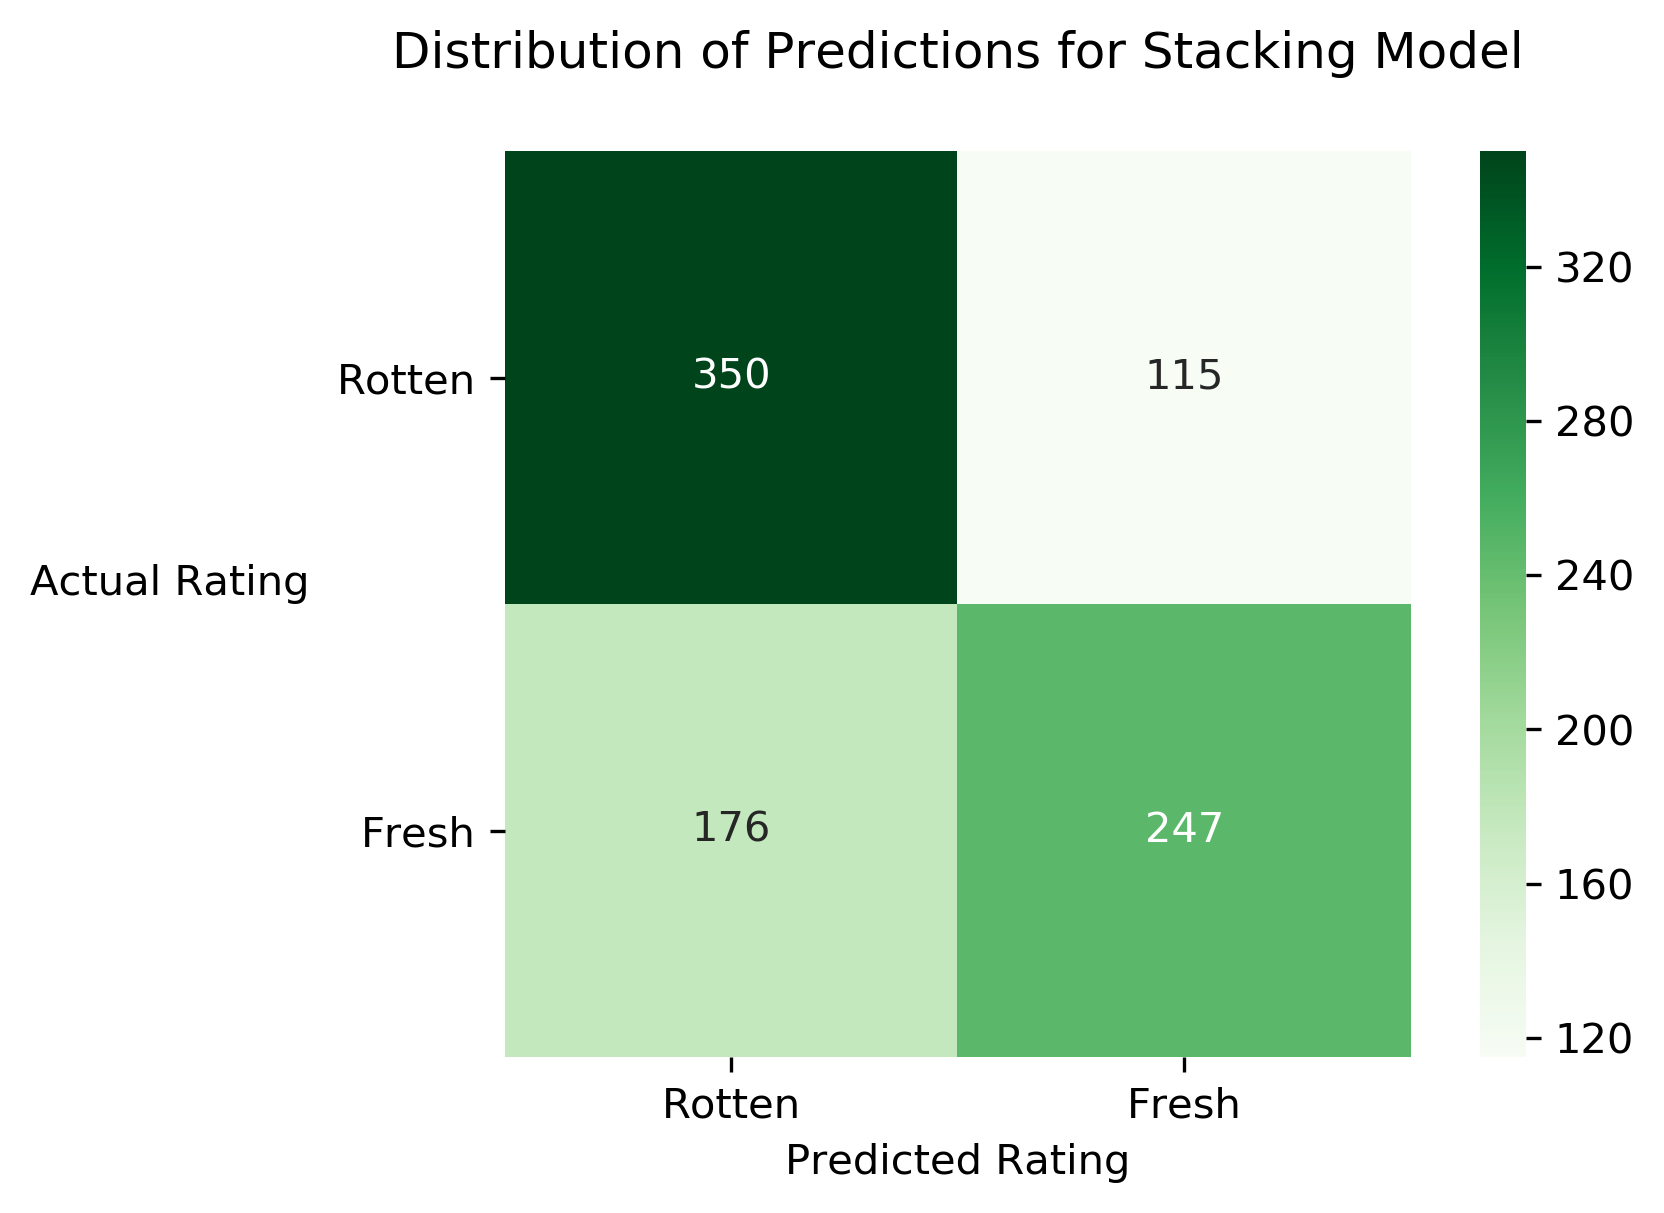

In [112]:
plt.figure(dpi=300)
ax = sns.heatmap(confusion_matrix(y_t,y_pred),cmap=plt.cm.Greens,
            annot=True,
            fmt='g',
            annot_kws = {'size':10},
            square=True,
            xticklabels=['Rotten','Fresh'],
            yticklabels=['Rotten','Fresh'],
                )
ax.set_yticklabels(ax.get_yticklabels(),rotation=360)
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating',rotation=360,labelpad=40)
plt.title('Distribution of Predictions for Stacking Model',pad=20)
plt.savefig('confusion_critic.svg');

### Save things!

In [8]:
import pickle

In [108]:
with open("Models/final_critic.pkl", "wb") as f:
    pickle.dump(final_mod, f)

In [50]:
with open("Models/critic_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

FileNotFoundError: [Errno 2] No such file or directory: 'Models/critic_scaler.pkl'